In [2]:
# import torch
# from torch.autograd import Variable
from sparse_identification.utils import derivative 
import pandas as pd

#--> Standard python library.
%pylab

#--> Matplotlib-related.
%matplotlib inline
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D

# params = {'text.usetex' : True,
#           'font.size' : 8*2,
#           'font.family' : 'lmodern',
#           'text.latex.unicode' : True}
# plt.rcParams['text.latex.preamble']=[r'\usepackage{lmodern}', r'\usepackage{bm}']
# plt.rcParams.update(params)
plt.style.use('seaborn-muted')

w = 10 # plot figure width

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell
    text-align: right;
    vertical-align: middle;
}
</style>
""")

# from latex_envs.latex_envs import figcaption

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


\title{A (very) quick introduction to SINDy}
\author{Kevin, Joel, Elbert$^1$}
\maketitle
$^1$Harvard University
<center>**Abstract**</center>
After a quick presentation of the training and testing datasets used, the system identification capabilities of SINDy are illustrated using time-series of the Lorenz system. Four different algorithms for system identification have been implemented so far and will be compared:
- Ordinary Least-Squares
- Sequentially hard-thresholded ordinary least-squares
- $\ell_1$-penalized least-squares.

Wait that's only 3 though\\

\begin{equation}
    \begin{aligned}
        & \dot{x} = \sigma (y-x) \\
        & \dot{y} = x(\rho -z) - y \\
        & \dot{z} = xy - \beta z
    \end{aligned}
    \label{eq: Lorenz system}
\end{equation}
Lorenz example $\sigma = 10$, $\beta = \displaystyle \frac{8}{3}$ and $\rho=28$.

In [3]:
def PCA_project(X, modes, plot_SVs=True):
    # SVD of X
    U, s, VT = np.linalg.svd(X)
    
    # construct S matrix with S_vector -- there must be a better way to do this?
    S = np.zeros([U.shape[0],VT.shape[0]])
    for i in range(modes):
        S[i,i] = s[i]

#     print("shapes", X.shape, U.shape,S.shape,VT[:,:modes].shape, (U@S@VT[:,:modes]).shape)
    plt.plot(np.log(s))
    plt.show()
    return np.matmul(U, np.matmul(S,VT[:,:modes]))

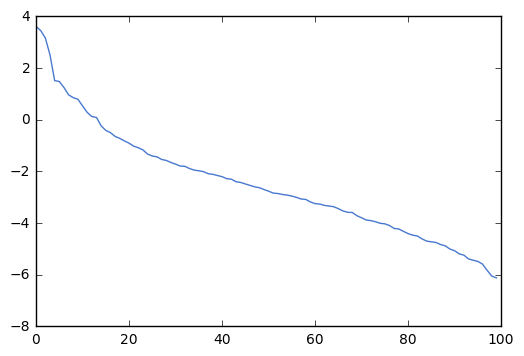

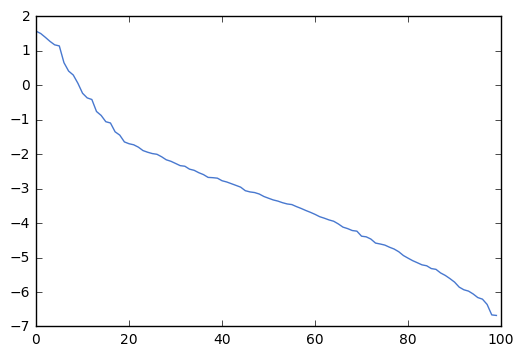

In [4]:
# --> Simulating the Lorenz system.
# from Lorenz import Lorenz
# --> Sets the parameters to their classical values.
# sigma, rho, beta = 10., 28., 8./3.

# --> Integration time.
t = np.linspace(0, 320, 320)
# 0,20,100

# --> Produce the date to be used in the sparse identification.
# x0 = np.array([-1, -1, -1]) # Initial condition.
# x, dx = Lorenz(x0, sigma, rho, beta, t)

fulldata = pd.read_csv("../../../rnndata/worldtour.csv", header = None).values
x = PCA_project(fulldata, 3, True)
dx = np.gradient(x)
dx = dx[0]
dx = PCA_project(dx, 3, True)
# use first element of dx, dx[0], to return time derivative dx/dt 
# dx0 = derivative(X, t[1]-t[0])
# --> Slightly different initial condition to highlight the chaotic nature. # hey we should try this too!
# y0 = np.array([-8.01, 7., 27.]) # Initial condition.
# y, dy = Lorenz(y0, sigma, rho, beta, t)

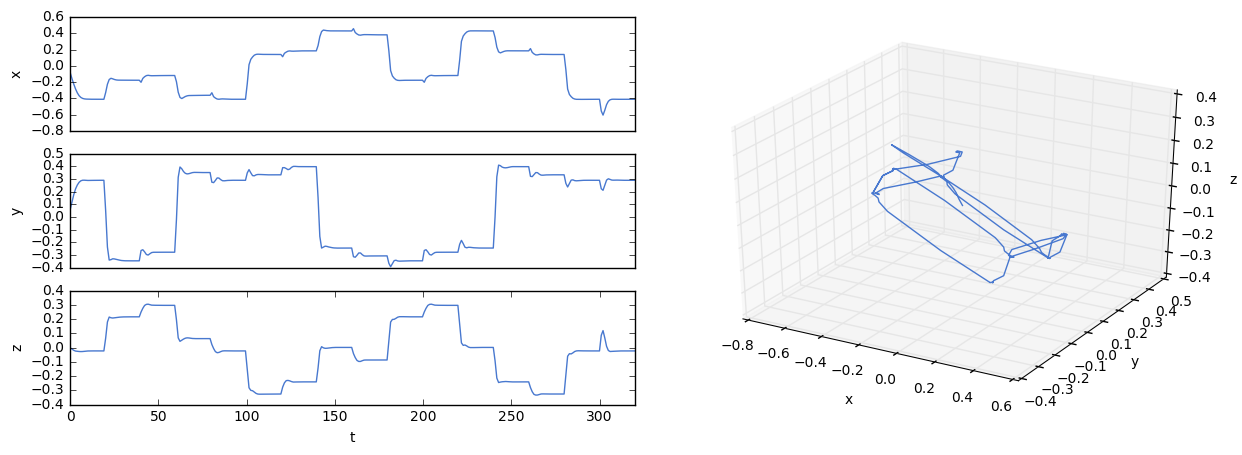

In [5]:
# --> Plot time traces of the two trajectories as well as the corresponding stange attractor.
fig = plt.figure(figsize=(1.5*w, w/2))
gs = GridSpec(3, 6)

ax0 = fig.add_subplot(gs[0, :3])
ax0.plot(t, x[:, 0])
# ax0.plot(t, y[:, 0])
ax0.set_ylabel('x')
ax0.set_xticks([])
ax0.set_xlim(0, 320)

ax1 = fig.add_subplot(gs[1, :3])
ax1.plot(t, x[:, 1])
# ax1.plot(t, y[:, 1])
ax1.set_ylabel('y')
ax1.set_xticks([])
ax1.set_xlim(0, 320)

ax2 = fig.add_subplot(gs[2, :3])
ax2.plot(t, x[:, 2])
# ax2.plot(t, y[:, 2])
ax2.set_ylabel('z')
ax2.set_xlabel('t')
ax2.set_xlim(0, 320)

ax3 = fig.add_subplot(gs[:, 3:], projection='3d')
ax3.plot(x[:, 0], x[:, 1], x[:, 2])
# ax3.plot(y[:, 0], y[:, 1], y[:, 2])
ax3.set_xlabel('x', labelpad=10)
ax3.set_ylabel('y')
ax3.set_zlabel('z')


Does our thing have sensitivity to initial conditions? \cite{book:sparrow:2012}

\section{Identification}

In the following, we will compare the capabilities of different algorithms used to solve the system identification problem presented earlier. For that purpose, the dictionary of functions considered is given by

$$
    \Theta({\bf x}) = \begin{bmatrix} 1 & {\bf x} & P_2({\bf x}) & P_3({\bf x}) & P_4({\bf x}) & P_5({\bf x}) \end{bmatrix}
$$

where $P_i({\bf x})$ is a dictionary consisting of all the i-th order polynomials in the entries of ${\bf x}$. For $i=2$, this dictionary is thus given by

$$
    P_2({\bf x}) = \begin{bmatrix} x^2 & xy & xz & y^2 & yz & z^2\end{bmatrix}
$$

The scikit-learn package provides useful utilities functions to construct such dictionaries of functions.

In [6]:
# --> Creation of the library Theta.
from sklearn.preprocessing import PolynomialFeatures
library = PolynomialFeatures(degree=5, include_bias=True)
# library.get_feature_names() or get_params()
Theta = library.fit_transform(x) # timesteps (320) by num_features (56)
n_lib = library.n_output_features_

from scipy.linalg import block_diag
A = block_diag(Theta, Theta, Theta) # need to increase this if more dimensions
b = dx.flatten(order='F')

\subsection{Ordinary least squares}

The ordinary least squares is probably the simplest approach existing for system identification. The corresponding minimization problem simply reads

\begin{equation}
    \min_{\xi_{OLS}} \| \Theta({\bf x})\xi_{OLS} - \dot{\bf x} \|_2^2
\end{equation}

In this case, the least-squares solution vector $\xi_{OLS}$ can very easily be obtained. Note however that, being unconstrained, this solution vector will be dense, i.e. all of its coefficients are non-zero.

In [18]:
%%time
# --> Least-squares estimator.
from sparse_identification import sindy
ols = sindy(l1=0, l2=0, solver='lstsq') # only 'lstsq' and 'lasso' are implemented

# --> Fit the OLS model.
ols.fit(A, b)
print 'Total number of possible terms :', ols.coef_.size
print 'Number of non-zero coefficients :', np.count_nonzero(ols.coef_)

Total number of possible terms : 168
Number of non-zero coefficients : 168
Wall time: 20 ms


In [170]:
# --> Print on-screen the coefficients of the OLS estimator.

print "Identified equation for x : \n"
print ols.coef_[:n_lib], "\n"
print "\n Identified equation for y : \n"
print ols.coef_[n_lib:2*n_lib], "\n"
print "\n Identified equation for z : \n"
print ols.coef_[2*n_lib:3*n_lib]

Identified equation for x : 

[-2.43930015e-02  5.47787299e+00  7.85660665e+00  7.62543304e+00
  1.47223485e+01  3.55221398e+01  4.97316747e+01  1.67056571e+01
  5.62788690e+01  4.32962013e+01 -2.89321438e+02 -1.05894244e+03
 -1.46001718e+03 -1.30651999e+03 -3.66132479e+03 -2.51508238e+03
 -5.44597693e+02 -2.40194079e+03 -3.47791602e+03 -1.58869911e+03
 -5.35035885e+01 -1.66168923e+02 -1.17079765e+02 -2.50250427e+02
 -8.38365432e+01  5.74617484e+01 -2.86918281e+02 -1.74977039e+02
  6.71050217e+02  2.79841569e+02 -1.12899204e+02 -2.65384958e+02
  2.66818240e+02  6.54939668e+02  1.45411272e+02  1.53781119e+03
  8.04698984e+03  1.37890043e+04  1.81859510e+04  5.89788996e+04
  5.38259640e+04  2.28782092e+04  1.03153815e+05  1.78294924e+05
  1.11020648e+05  1.58759463e+04  8.90281968e+04  2.13182112e+05
  2.53301499e+05  1.17731568e+05  4.60120203e+03  3.18745143e+04
  9.55857077e+04  1.59162835e+05  1.42636711e+05  5.19405664e+04] 


 Identified equation for y : 

[-9.52884197e-02 -8.92141

As shown, all of the coefficients of the solution $\xi_{OLS}$ are effectively non-zero. From a mathematical point of view, this denseness of $\xi_{OLS}$ indicates that the ordinary least-squares estimator uses absolutely all of the atoms included in our input dictionary $\Theta({\bf x})$ to approximate the true function $\mathcal{f}({\bf x})$. Given the simplicity of the Lorenz system \eqref{eq: Lorenz system}, this behavior is clearly related to *overfitting*, a well-known problem of regression. Note moreover that, when simulating the identified model, the inclusion of all the extra terms may slow down the computation or even cause numerical instabilities.

\subsection{$\ell_1$-penalized least squares}

A good heuristic to obtain a sparse solution vector $\xi$ is to replace the nuclear norm $\| \xi \|_0$ by its 1-norm $\| \xi \|_1$ in the original problem. The resulting minimization problem reads

\begin{equation}
        \min_{\xi} \| \Theta({\bf x})\xi - \dot{\bf x} \|_2^2 \\
        \text{s. t. }  \| \xi \|_1 \le \alpha
\end{equation}

where $\alpha$ is typically chosen as a fraction of $\| \xi_{OLS} \|_1$. This problem is a convex minimization problem which can easily be solved using standard convex optimization libraries. Note however that, although the resulting solution vector $\xi_{\ell_1}$ is sparse, it is usually not the optimal solution. Hence, once the sparsity pattern of $\xi$ has been determined, one then runs an additional ordinary least-squares regression retaining only the atoms of $\Theta({\bf x})$ corresponding to non-zero entries of $\xi_{\ell_1}$.

In [171]:
%%time
# --> l1-penalized estimator.
from sparse_identification import sindy
l1_penalized = sindy(l1=0.01, solver='lasso')

# --> Fit the OLS model.
l1_penalized.fit(A, b)
print 'Total number of possible terms :', l1_penalized.coef_.size
print 'Number of non-zero coefficients :', np.count_nonzero(l1_penalized.coef_)

     pcost       dcost       gap    pres   dres
 0: -6.9607e-03 -1.5326e+03  2e+03  2e-16  6e+01
 1: -1.0447e-02 -2.4057e+01  2e+01  9e-16  9e-01
 2: -2.9814e-02 -2.6804e+00  3e+00  8e-16  1e-01
 3: -9.2950e-02 -1.4141e+00  1e+00  4e-17  3e-02
 4: -1.5927e-01 -7.0670e-01  5e-01  2e-16  6e-03
 5: -2.0485e-01 -3.6967e-01  2e-01  9e-16  7e-04
 6: -2.2581e-01 -2.6864e-01  4e-02  1e-16  2e-14
 7: -2.3246e-01 -2.4156e-01  9e-03  5e-16  3e-14
 8: -2.3423e-01 -2.3604e-01  2e-03  1e-16  2e-14
 9: -2.3466e-01 -2.3497e-01  3e-04  7e-16  4e-14
10: -2.3476e-01 -2.3480e-01  5e-05  3e-16  4e-14
11: -2.3478e-01 -2.3478e-01  7e-06  8e-16  3e-14
12: -2.3478e-01 -2.3478e-01  7e-07  6e-16  4e-14
13: -2.3478e-01 -2.3478e-01  2e-08  1e-16  4e-14
Optimal solution found.
Total number of possible terms : 168
Number of non-zero coefficients : 162
CPU times: user 117 ms, sys: 16.9 ms, total: 134 ms
Wall time: 88 ms


/Users/kevinstephen/anaconda3/envs/sindy/lib/python2.7/site-packages/cvxopt/coneprog.py:4345: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if solver == 'mosek':


In [172]:
# --> Print on-screen the coefficients of the l1-penalized estimator.

print "Identified equation for x : \n"
print l1_penalized.coef_[:n_lib], "\n"
print "\n Identified equation for y : \n"
print l1_penalized.coef_[n_lib:2*n_lib], "\n"
print "\n Identified equation for z : \n"
print l1_penalized.coef_[2*n_lib:3*n_lib]

Identified equation for x : 

[ 0.          0.31088317 -0.04685538  0.34229397  0.47610067  0.13850026
  0.0467095  -0.39290242 -2.13532028 -1.61157867 -4.3100762  -5.3843256
 -3.64664522 -2.16825995 -0.81563672  6.32347437  3.54629599  1.83342066
 -1.63217147 -1.55957937 -2.50801124 -0.40357577 -4.1610987   1.29505635
  3.30875784 -0.5903071  -3.73775763  1.37885739 -3.06950721  2.74290689
 -2.06700781 -0.53398399  1.72304375 -0.9630976   0.04987399  0.44591508
 -3.99976161  0.54428426  4.35524373 -0.71440549  0.56302647 -2.03865965
 -0.90864585  0.91345496 -0.89978953 -1.88383648  1.95666613 -0.81876232
  0.17748689  0.21604185  0.22407618  0.11887023 -0.56310814  0.63531062
 -0.60139261  0.50020349] 


 Identified equation for y : 

[  0.           0.39172257   1.47053293   2.92370642  -1.88767305
  -0.63827181   0.28618668   0.89093657   1.98072136   0.94451499
   6.15868177   2.26186519  -9.21617331  -2.77457578   9.05215797
   1.77997339  -7.66056732 -10.37117614   5.22055994  -7

The $\ell_1$-penalized estimator retains only 7 atoms out of the 168 available ones in $\Theta({\bf x})$. As will be shown, discarding these 161 extra atoms hardly influences the accuracy of the fit. Moreover, the coefficients identified are very close to the actual ones used in the definition of system \eqref{eq: Lorenz system}.

\subsection{Sequentially hard-thresholded ordinary least squares}

The last algorithm considered is the one presented in \cite{pnas:brunton:2016}. It is an iteratively hard-thresholded least-squares approach. At each iteration, only the atoms of $\Theta({\bf x})$ for which

$$
    \vert \xi_i \vert > \ell_1 \displaystyle \frac{1}{n}\sum_{j=1}^n \vert \xi_j \vert
$$

are retained. Note that only the non-zero entries of $\xi$ are considered when evaluating the mean absolute value.

In [177]:
%%time
# --> Sequentially hard-thresholded estimator.
from sparse_identification import sindy
shols = sindy(l1=0.5, solver='lstsq')

# --> Fit the OLS model.
shols.fit(A, b)
print 'Total number of possible terms :', shols.coef_.size
print 'Number of non-zero coefficients :', np.count_nonzero(shols.coef_)

Total number of possible terms : 168
Number of non-zero coefficients : 21
CPU times: user 12.1 ms, sys: 1.89 ms, total: 14 ms
Wall time: 10.8 ms


In [178]:
# --> Print on-screen the coefficients of the SH-OLS estimator.

print "Identified equation for x : \n"
print shols.coef_[:n_lib], "\n"
print "\n Identified equation for y : \n"
print shols.coef_[n_lib:2*n_lib], "\n"
print "\n Identified equation for z : \n"
print shols.coef_[2*n_lib:3*n_lib]

Identified equation for x : 

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -1.56952084 -3.67132612
  0.          0.          0.          6.19253133  1.84305136  0.
 -3.34271369  0.          0.          0.          0.          0.
 -2.62681654  0.          0.          3.38033288  0.          2.23790961
  0.          0.          1.82356233  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -7.9677315   1.13842844  0.
  0.          0.          0.          0.          0.          0.
  0.          0.        ] 


 Identified equation for y : 

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          2.45005459  3.89379268
  0.          0.          0.         -1.03106008  0.          0.
  0.          0.          0.          0.         -1.74327407  0.
  0.35423993  2.75063394  0.          0. 

The sparsity patterns of the solution vector $\xi$ obtained using the $\ell_1$-penalized least-squares estimator or the present sequentially hard-thresholded one are identical. Not however that may not always be true, although they usually marginally differ from one another.

\subsection{Comparison of the predicted dynamics}

/Users/kevinstephen/anaconda3/envs/sindy/lib/python2.7/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


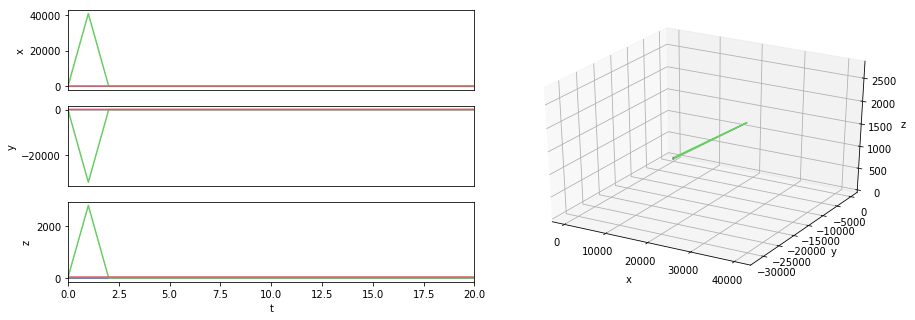

In [179]:
# --> Run the different identified models.
from scipy.integrate import odeint
from Lorenz import Identified_Model
x_ols = odeint(Identified_Model, y0, t, args=(library, ols))
x_shols = odeint(Identified_Model, y0, t, args=(library, shols))

# --> Plot the results.
fig = plt.figure(figsize=(1.5*w, w/2))
gs = GridSpec(3, 6)

ax0 = fig.add_subplot(gs[0, :3])
ax0.plot(t, x[:, 0])
ax0.plot(t, x_ols[:, 0])
ax0.plot(t, x_shols[:, 0])
ax0.set_ylabel('x')
ax0.set_xticks([])
ax0.set_xlim(0, 20)

ax1 = fig.add_subplot(gs[1, :3])
ax1.plot(t, x[:, 1])
ax1.plot(t, x_ols[:, 1])
ax1.plot(t, x_shols[:, 1])
ax1.set_ylabel('y')
ax1.set_xticks([])
ax1.set_xlim(0, 20)

ax2 = fig.add_subplot(gs[2, :3])
ax2.plot(t, x[:, 2])
ax2.plot(t, x_ols[:, 2])
ax2.plot(t, x_shols[:, 2])
ax2.set_ylabel('z')
ax2.set_xlabel('t')
ax2.set_xlim(0, 20)

ax3 = fig.add_subplot(gs[:, 3:], projection='3d')
ax3.plot(x[:, 0], x[:, 1], x[:, 2])
ax3.plot(x_ols[:, 0], x_ols[:, 1], x_ols[:, 2])
ax3.plot(x_shols[:, 0], x_shols[:, 1], x_shols[:, 2])
ax3.set_xlabel('x', labelpad=10)
ax3.set_ylabel('y')
ax3.set_zlabel('z')
ax3.locator_params(axis='x', nbins=5)

# figcaption('(Left) Time-traces of the different state variables and (right) corresponding trajectories in the three-dimensional phase space. \
#             In all figures, blue lines denote the ground truth evolution, while green and red are the predictions of the OLS and SH-OLS models.')

# References

[<a id="cit-book:sparrow:2012" href="#call-book:sparrow:2012">1</a>] C. Sparrow, ``_The Lorenz equations: bifurcations, chaos, and strange attractors_'',  2012.

[<a id="cit-pnas:brunton:2016" href="#call-pnas:brunton:2016">2</a>] Brunton Steven L, Proctor Joshua L and Kutz J Nathan, ``_Discovering governing equations from data by sparse identification of nonlinear dynamical systems_'', Proceedings of the National Academy of Sciences, vol. 113, number 15, pp. 3932--3937,  2016.

